In [2]:
import sys
sys.path.append('../spp')

import process
import market
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
tickers = ["TSLA", "AAPL", "MSFT", "AMZN", "GOOGL"]
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22


def_pipe = process.RsiBinPipeline(tickers, period="5y", test_coef=0.22)
X_train, y_train, X_test, y_test = def_pipe.get_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_list[i]["RSI"] = _rsi(dataframe)


In [3]:
X_train.shape

(4970, 28)

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_train[X_train > 1] /= 100

In [33]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.longlong).flatten()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training_data = CustomStockDataset(X_train, y_train)
test_data = CustomStockDataset(X_test, y_test)

In [34]:
type(training_data[0][1])

numpy.int64

In [35]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

## Convolutional NN

In [52]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class StockCNNv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 8, 3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, 2, padding=1)
        self.conv3 = nn.Conv1d(16, 32, 3, padding=1)
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.LazyLinear(16)
        self.fc3 = nn.LazyLinear(2)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.softmax(x)
        return x


torch_model = StockCNNv1()
summary(torch_model, (2, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 8, 14]              56
         MaxPool1d-2                 [-1, 8, 7]               0
            Conv1d-3                [-1, 16, 8]             272
         MaxPool1d-4                [-1, 16, 4]               0
            Conv1d-5                [-1, 32, 4]           1,568
         MaxPool1d-6                [-1, 32, 2]               0
            Linear-7                   [-1, 64]           4,160
            Linear-8                   [-1, 16]           1,040
            Linear-9                    [-1, 2]              34
Total params: 7,130
Trainable params: 7,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
-----------------------------------------------

[1,   400] loss: 0.693 test acc: 0.490
[1,   800] loss: 0.691 test acc: 0.490
[1,  1200] loss: 0.693 test acc: 0.490
[2,   400] loss: 0.691 test acc: 0.490
[2,   800] loss: 0.693 test acc: 0.490
[2,  1200] loss: 0.691 test acc: 0.490
[3,   400] loss: 0.687 test acc: 0.490
[3,   800] loss: 0.696 test acc: 0.490
[3,  1200] loss: 0.692 test acc: 0.490
[4,   400] loss: 0.695 test acc: 0.490
[4,   800] loss: 0.690 test acc: 0.490
[4,  1200] loss: 0.691 test acc: 0.490
[5,   400] loss: 0.693 test acc: 0.490
[5,   800] loss: 0.691 test acc: 0.490
[5,  1200] loss: 0.693 test acc: 0.490
[6,   400] loss: 0.690 test acc: 0.490
[6,   800] loss: 0.692 test acc: 0.490
[6,  1200] loss: 0.694 test acc: 0.490
[7,   400] loss: 0.691 test acc: 0.490
[7,   800] loss: 0.688 test acc: 0.490
[7,  1200] loss: 0.694 test acc: 0.490
[8,   400] loss: 0.693 test acc: 0.490
[8,   800] loss: 0.692 test acc: 0.490
[8,  1200] loss: 0.691 test acc: 0.490
[9,   400] loss: 0.692 test acc: 0.490
[9,   800] loss: 0.691 te

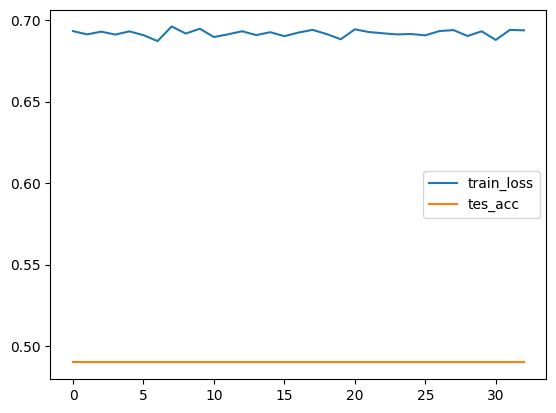

Finished Training


In [54]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(torch_model.parameters(), lr=0.005, momentum=0.9)

train_loss = []
test_acc = []

for epoch in range(10+1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], 2, 14]))
#         print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = 400
        if i % step == step - 1: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} ', end='')
            train_loss.append(running_loss / step)
            running_loss = 0.0

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], 2, 14]))
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

                print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))

plt.plot(train_loss, label="train_loss")
plt.plot(test_acc, label="tes_acc")
plt.legend()
plt.show()

print('Finished Training')

In [61]:
class TorchModel:
    def __init__(self, model):
        self.model = model

    def fit(self, x_data, y_data):
        return self

    def predict(self, data):
        y_preds = None
        with torch.inference_mode(): 
            y_preds = self.model(torch.tensor(np.array(data).astype(np.float32).reshape([data.shape[0], 2, 14]), dtype=torch.float))
            y_preds = np.argmax(np.array(y_preds), axis=1)
        return pd.DataFrame(y_preds)
    
    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)

Model earned 28195.33$ out of 492214245.89$ starting from 100000$ 
Train accuracy 0.54 
Test accuracy  0.49


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


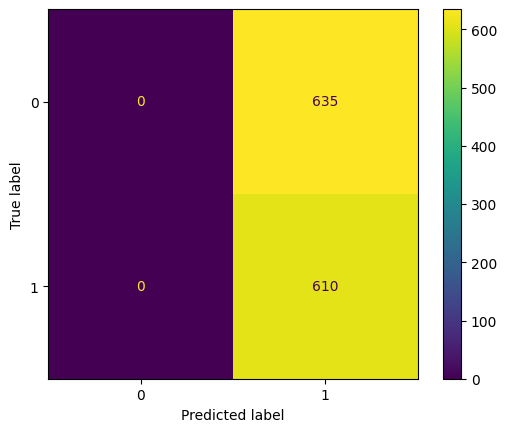

In [57]:
model = TorchModel(torch_model)
y_train_pred_bin = model.predict(X_train)
y_test_pred_bin = model.predict(X_test)

df = def_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
                                               # ! proposed bin not price

start_capital = 100000
tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
traded_capital = tt.trade()
maximal_caital = bt.trade()
print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {model.score(X_train, y_train):.2f} \nTest accuracy  {model.score(X_test, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)

## Corruption research

Corruption: 0.50, thr: 0.5
Corruption: 0.49, thr: 0.6
Corruption: 0.49, thr: 0.7
Corruption: 0.44, thr: 0.8
Corruption: 0.27, thr: 0.9


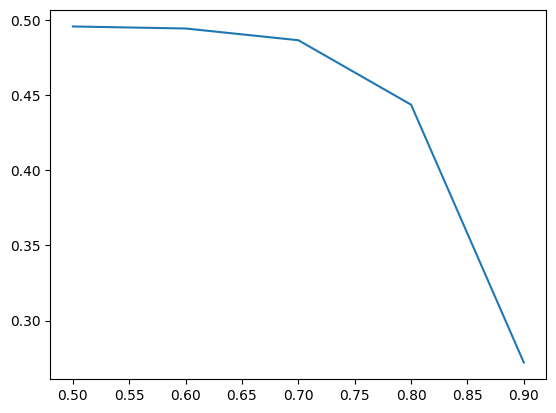

In [81]:
thresholds = [i / 10 for i in range(5, 10)]
window_size = 15

corruptions = []

for threshold in thresholds:
    y_train_close = y_train.reset_index(drop=True)

    X_train_close = X_train.drop(columns=[f"RSI_{i}" for i in range(window_size-1)]).reset_index(drop=True)
    X_train_close_tmp = X_train_close.transpose().corr().abs()
    X_train_close_tmp[X_train_close_tmp > threshold] = 1
    X_train_close_tmp[X_train_close_tmp <= threshold] = 0

    X_np = X_train_close_tmp.to_numpy()
    y_np = y_train_close.to_numpy().squeeze()

    false_correlated = sum(map(lambda x: int(y_np[x[0]] != y_np[x[1]]), zip(*np.where(X_np > threshold))))
    
    corruptions.append(( false_correlated / (np.count_nonzero(X_np) - len(y_np)))) 
    print(f"Corruption: {( false_correlated / (np.count_nonzero(X_np) - len(y_np))):.2f}, thr: {threshold}")

plt.plot(thresholds, corruptions)

## Data improve

In [1]:
import sys
sys.path.append('../spp')

import process
import market
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

from process import *

def TempTrainValidTestStage(valid=0.2, test=0.2):
    """
    Stage
    foreach append train & valid & test datasets instead
    """
    def _trainvalidtest_stage(dataframe_list: list):
        new_dataframe_list = []
        for i, dataframe in enumerate(dataframe_list):
            train_count = round((1. - test - valid) * len(dataframe))
            valid_count = round(valid * len(dataframe))
#             print(train_count, valid_count, len(dataframe))
            new_dataframe_list.append(dataframe[:train_count])
            new_dataframe_list.append(dataframe[train_count:train_count+valid_count])
            new_dataframe_list.append(dataframe[train_count+valid_count:])
        print(len(new_dataframe_list))
        return new_dataframe_list
    return _trainvalidtest_stage

def TempTargetsSeparateStage(target_names=["Target"]):
    """
    Stage
    foreach take out 'target_names' and append it as another dataset
    """
    def _targetsseparate_stage(dataframe_list: list):
        new_dataframe_list = []
        for i, dataframe in enumerate(dataframe_list):
            columns_to_keep = [col for col in dataframe.columns if col not in target_names]
            print(target_names)
            new_dataframe_list.append(dataframe[columns_to_keep])
            new_dataframe_list.append(dataframe[target_names])
            print(len(new_dataframe_list), dataframe[columns_to_keep].shape, dataframe[target_names].shape)
        return new_dataframe_list
    return _targetsseparate_stage

class HistBinPipeline(DefaultPipeline):        
    def _stages(self):
        stages=[
            # Open processing
            DivStage("Open", "Close", "Open_Rel"),
            DropStage(["Open"]),
            # High processing
            DivStage("High", "Close", "High_Rel"),
            DropStage(["High"]),
            # Low processing
            DivStage("Low", "Close", "Low_Rel"),
            DropStage(["Low"]),
            # AdjClose processing
            DropStage(["Adj Close"]),
            # Volume processing
            DropStage(["Volume"]),
            
            # RSI
            RSIColStage("Close"),
            
            LnProfStage("Close"),
            WindowStage(self.window_size),
            TargetStage(f"Close_LnProf_{self.window_size-1}"),

            BinarizeStage(0., "Target"),
            DropStage(["Target"]),
            TargetStage("Target_Bin"),
            
            DropStage([f"Open_Rel_{self.window_size-1}"]),
            DropStage([f"High_Rel_{self.window_size-1}"]),
            DropStage([f"Low_Rel_{self.window_size-1}"]),

            DropStage([f"Close_{i}" for i in range(self.window_size-2)]),
            DropStage([f"RSI_{self.window_size-1}"]),
            
            TempTrainValidTestStage(valid=self.test_coef,test=self.test_coef),
#             TrainTestStage(test=self.test_coef),
            
            PopStage([f"Close_{self.window_size-2}"], self.prev_price_keeper),
            PopStage([f"Close_{self.window_size-1}"], self.true_price_keeper),
            TempTargetsSeparateStage(),
        ]
        return stages


In [53]:
tickers = ["TSLA"]#, "AAPL", "MSFT", "AMZN", "GOOGL"]
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22
window_size = 15

def_pipe = HistBinPipeline(tickers, period="5y", test_coef=2/5, window_size=window_size)
datas = def_pipe.get_data()
for item in datas:
    print(item.shape)

[*********************100%***********************]  1 of 1 completed
PREP: 1 <function DivStage.<locals>._div_stage at 0x000002468303A4D0>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A0E0>
PREP: 1 <function DivStage.<locals>._div_stage at 0x000002468303A680>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A7A0>
PREP: 1 <function DivStage.<locals>._div_stage at 0x000002468303A710>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A200>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A950>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A290>
PREP: 1 <function RSIColStage.<locals>._rsicol_stage at 0x000002468303A9E0>
PREP: 1 <function LnProfStage.<locals>._lnprof_stage at 0x000002468303A8C0>
PREP: 1 <function WindowStage.<locals>._window_stage at 0x000002468303AB90>
PREP: 1 <function TargetStage.<locals>._target_stage at 0x000002468303ACB0>
PREP: 1 <function BinarizeStage.<locals>._binarize_stage 

In [3]:
import datetime

In [4]:
datetime.datetime.now().date().__str__()

'2023-05-14'

In [35]:
thresholds = [i / 10 for i in range(5, 10)]

corruptions = []

def threshold_corr(dataset, name_prefix, threshold, window_size):
    X_1 = dataset[[f"{name_prefix}_{i}" for i in range(window_size-1)]].reset_index(drop=True)
    X_1 = X_1.transpose().corr().abs()
    X_1[X_1 > threshold] = 1
    X_1[X_1 <= threshold] = 0
    return X_1

y_train_close = y_train.reset_index(drop=True)
y_np = y_train_close.to_numpy().squeeze()

for threshold in thresholds:
    
    X_open = threshold_corr(X_train, "Open_Rel", threshold, window_size)
    X_lnclose = threshold_corr(X_train, "Close_LnProf", threshold, window_size)
    X_high = threshold_corr(X_train, "High_Rel", threshold, window_size)
    X_low = threshold_corr(X_train, "Low_Rel", threshold, window_size)
    parts = 4. - 0.5

    X_np = (X_open + X_lnclose + X_high + X_low).to_numpy()

    false_correlated = sum(map(lambda x: int(y_np[x[0]] != y_np[x[1]]), zip(*np.where(X_np > parts))))
    
    corruptions.append( false_correlated / (np.count_nonzero(X_np) - len(y_np)) ) 
    print(f"Corruption: {( false_correlated / (np.count_nonzero(X_np) - len(y_np))):.2f}, thr: {threshold}")

   
plt.plot(thresholds, corruptions)

Corruption: 0.00, thr: 0.5
Corruption: 0.00, thr: 0.6


ZeroDivisionError: division by zero

[5,     2] loss: 0.040 | test acc: 0.562 | train acc 1.000

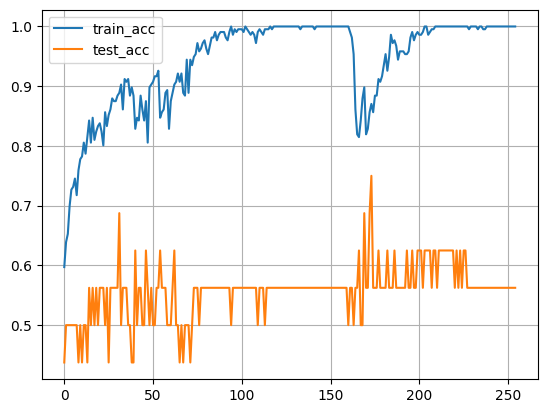

Finished Training


In [451]:

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#         print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = len(train_dataloader)
        if i % step == step - 1: 
            
            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(train_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                train_loss.append(predicred_true/ len(train_dataloader.dataset))
#             train_loss.append(running_loss / step)

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#                     print("Output", outputs)
#                     print("Output", torch.argmax(outputs, dim=1))
#                     print("labels", labels)
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))
            print(f'\r[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} | test acc: {predicred_true/ len(test_dataloader.dataset):.3f} | train acc {train_loss[-1]:.3f}', end='', flush=True)
            running_loss = 0.0
            
            if predicred_true / len(test_dataloader.dataset) > best_acc:
                best_model = copy.deepcopy(torch_model)
                best_acc = predicred_true/ len(test_dataloader.dataset)
                
plt.plot(train_loss, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')

In [54]:
tickers = ["TSLA"]#, "AAPL", "MSFT", "AMZN", "GOOGL"]
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22
window_size = 15

def_pipe = HistBinPipeline(tickers, period="1y", test_coef=1/12, window_size=window_size)
X_train, y_train, X_valid, y_valid, X_test, y_test = def_pipe.get_data()

[*********************100%***********************]  1 of 1 completed
PREP: 1 <function DivStage.<locals>._div_stage at 0x000002468316FBE0>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x00000246FFDC44C0>
PREP: 1 <function DivStage.<locals>._div_stage at 0x000002468303A4D0>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A0E0>
PREP: 1 <function DivStage.<locals>._div_stage at 0x000002468303A680>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A7A0>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A710>
PREP: 1 <function DropStage.<locals>._drop_stage at 0x000002468303A200>
PREP: 1 <function RSIColStage.<locals>._rsicol_stage at 0x000002468303A950>
PREP: 1 <function LnProfStage.<locals>._lnprof_stage at 0x000002468303A290>
PREP: 1 <function WindowStage.<locals>._window_stage at 0x000002468303A9E0>
PREP: 1 <function TargetStage.<locals>._target_stage at 0x000002468303A8C0>
PREP: 1 <function BinarizeStage.<locals>._binarize_stage 

In [55]:
X_train = X_train[:len(X_train) // 8 * 8]
X_valid = X_valid[:len(X_valid) // 8 * 8]
X_test = X_test[:len(X_test) // 8 * 8]

y_train = y_train[:len(y_train) // 8 * 8]
y_valid = y_valid[:len(y_valid) // 8 * 8]
y_test = y_test[:len(y_test) // 8 * 8]

len(X_train), len(X_valid), len(X_test)

(192, 16, 16)

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_Rel_0       192 non-null    float64
 1   Open_Rel_1       192 non-null    float64
 2   Open_Rel_2       192 non-null    float64
 3   Open_Rel_3       192 non-null    float64
 4   Open_Rel_4       192 non-null    float64
 5   Open_Rel_5       192 non-null    float64
 6   Open_Rel_6       192 non-null    float64
 7   Open_Rel_7       192 non-null    float64
 8   Open_Rel_8       192 non-null    float64
 9   Open_Rel_9       192 non-null    float64
 10  Open_Rel_10      192 non-null    float64
 11  Open_Rel_11      192 non-null    float64
 12  Open_Rel_12      192 non-null    float64
 13  Open_Rel_13      192 non-null    float64
 14  High_Rel_0       192 non-null    float64
 15  High_Rel_1       192 non-null    float64
 16  High_Rel_2       192 non-null    float64
 17  High_Rel_3      

In [57]:
X_train[[f"RSI_{i}" for i in range(14)]] /= 100
X_valid[[f"RSI_{i}" for i in range(14)]] /= 100
X_test[[f"RSI_{i}" for i in range(14)]] /= 100
X_train[[f"RSI_{i}" for i in range(14)]]

,RSI_0,RSI_1,RSI_2,RSI_3,RSI_4,RSI_5,RSI_6,RSI_7,RSI_8,RSI_9,RSI_10,RSI_11,RSI_12,RSI_13
0,0.000000,0.470024,0.275822,0.274901,0.193635,0.251239,0.189344,0.309446,0.449665,0.553280,0.550335,0.512003,0.573875,0.447739
1,0.470024,0.275822,0.274901,0.193635,0.251239,0.189344,0.309446,0.449665,0.553280,0.550335,0.512003,0.573875,0.447739,0.467650
2,0.275822,0.274901,0.193635,0.251239,0.189344,0.309446,0.449665,0.553280,0.550335,0.512003,0.573875,0.447739,0.467650,0.470961
3,0.274901,0.193635,0.251239,0.189344,0.309446,0.449665,0.553280,0.550335,0.512003,0.573875,0.447739,0.467650,0.470961,0.487815
4,0.193635,0.251239,0.189344,0.309446,0.449665,0.553280,0.550335,0.512003,0.573875,0.447739,0.467650,0.470961,0.487815,0.475979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.662609,0.716496,0.732226,0.638888,0.662686,0.589667,0.604634,0.609946,0.574303,0.623393,0.609866,0.588797,0.511906,0.548743
188,0.716496,0.732226,0.638888,0.662686,0.589667,0.604634,0.609946,0.574303,0.623393,0.609866,0.588797,0.511906,0.548743,0.524135
189,0.732226,0.638888,0.662686,0.589667,0.604634,0.609946,0.574303,0.623393,0.609866,0.588797,0.511906,0.548743,0.524135,0.488013
190,0.638888,0.662686,0.589667,0.604634,0.609946,0.574303,0.623393,0.609866,0.588797,0.511906,0.548743,0.524135,0.488013,0.456312


## Convolutional NN: Second try

In [58]:
CHANNELS = 5

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.longlong).flatten()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training_data = CustomStockDataset(X_train, y_train)
valid_data = CustomStockDataset(X_valid, y_valid)
test_data = CustomStockDataset(X_test, y_test)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=True)

In [59]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class StockCNNv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(5, 8, 3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(8, 16, 2, padding=1)
        self.conv3 = nn.Conv1d(16, 32, 3, padding=1)
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.LazyLinear(16)
        self.fc3 = nn.LazyLinear(2)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.softmax(x)
        return x


torch_model = StockCNNv1()
summary(torch_model, (5, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 8, 14]             128
            Linear-2                   [-1, 64]           7,232
            Linear-3                    [-1, 2]             130
Total params: 7,490
Trainable params: 7,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


C:\Users\valer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [60]:
class forecasting_model(nn.Module):
    
    def __init__(self, input_features, output_features, print_shapes = False):
        super().__init__()
        self.conv    = nn.Conv1d(in_channels = input_features, out_channels = 128, kernel_size = 3, padding = 1)
        self.pool1   = nn.AdaptiveAvgPool1d(1)
        self.pool2   = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.bn      = nn.BatchNorm1d(num_features = 2 * 128)
        self.relu    = nn.ReLU()
        self.fc      = nn.Linear(in_features = 2 * 128, out_features = output_features)
        self.print_shapes = print_shapes
        
    def forward(self, x):
        
        if self.print_shapes: print(f"{'Input Batch Shape':<25} {x.shape}")
        
        conv_op = self.conv(x)
        if self.print_shapes: print(f"{'Conv Output Shape':<25} {conv_op.shape}")
        
        avg_pool = self.pool1(conv_op)
        max_pool = self.pool2(conv_op)
        final_pool = torch.cat([avg_pool, max_pool], dim = -1)
        flattened_op = self.flatten(final_pool)
        if self.print_shapes: print(f"{'Pooled Output Shape':<25} {flattened_op.shape}")
        
        final_op = self.fc(self.bn(self.relu(flattened_op)))
        if self.print_shapes: print(f"{'Output Shape':<25} {final_op.shape}")
            
        return final_op
    
torch_model = forecasting_model(CHANNELS, 2, False)
summary(torch_model, (CHANNELS, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 14]           2,048
 AdaptiveAvgPool1d-2               [-1, 128, 1]               0
 AdaptiveMaxPool1d-3               [-1, 128, 1]               0
           Flatten-4                  [-1, 256]               0
              ReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                    [-1, 2]             514
Total params: 3,074
Trainable params: 3,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [61]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(torch_model.parameters(), lr = 3e-3, momentum=0.9)
train_loss = []
valid_loss = []
test_acc = []

best_model = None
best_acc = 0

In [62]:
len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(24, 2, 2)

In [ ]:
[1234|5]
[2345|6]
-----+-
[3456|7]

In [63]:
import copy

[20,     2] loss: 0.047 | test acc: 0.625 | valid acc: 0.438 | train acc 1.000

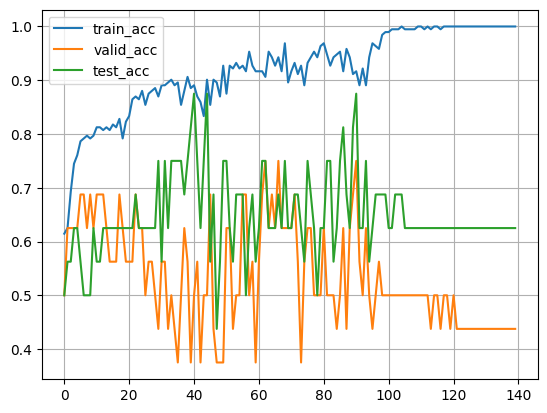

Finished Training


In [70]:

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#         print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = len(train_dataloader)
        if i % step == step - 1: 
            
            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(train_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                train_loss.append(predicred_true/ len(train_dataloader.dataset))
#             train_loss.append(running_loss / step)

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#                     print("Output", outputs)
#                     print("Output", torch.argmax(outputs, dim=1))
#                     print("labels", labels)
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))
    
            predicred_true = 0
            with torch.no_grad():
                for i, data in enumerate(valid_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#                     print("Output", outputs)
#                     print("Output", torch.argmax(outputs, dim=1))
#                     print("labels", labels)
                    predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                valid_loss.append(predicred_true/ len(test_dataloader.dataset))

            print(f'\r[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} | test acc: {test_acc[-1]:.3f} | valid acc: {valid_loss[-1]:.3f} | train acc {train_loss[-1]:.3f}', end='', flush=True)
            running_loss = 0.0
            
            if predicred_true / len(test_dataloader.dataset) > best_acc:
                best_model = copy.deepcopy(torch_model)
                best_acc = predicred_true/ len(test_dataloader.dataset)
                
plt.plot(train_loss, label="train_acc")
plt.plot(valid_loss, label="valid_acc")
plt.plot(test_acc, label="test_acc")
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')

In [20]:
len(test_dataloader.dataset), len(test_dataloader)

(16, 2)

In [71]:
class TorchModel:
    def __init__(self, model):
        self.model = model

    def fit(self, x_data, y_data):
        return self

    def predict(self, dataloader):
        y_preds = []
        with torch.no_grad():
            predicred_true = 0
            for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                outputs = self.model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                y_preds += torch.argmax(outputs, dim=1).tolist()

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
#             train_loss.append(running_loss / step)

        return pd.DataFrame(y_preds)
    
    def score(self, x_dataloader, y_data):
        if len(y_data) != len(x_dataloader.dataset):
            raise Exception("Different data length")
#         print(np.array(self.predict(x_dataloader)).flatten() == np.array(y_data).flatten())
        return sum(np.array(self.predict(x_dataloader)).flatten() == np.array(y_data).flatten()) / len(y_data)

In [ ]:
[askdv]
[skdva]
--------
[kdvas]

Train accuracy 0.91
Valid accuracy 0.75
Test accuracy  0.75


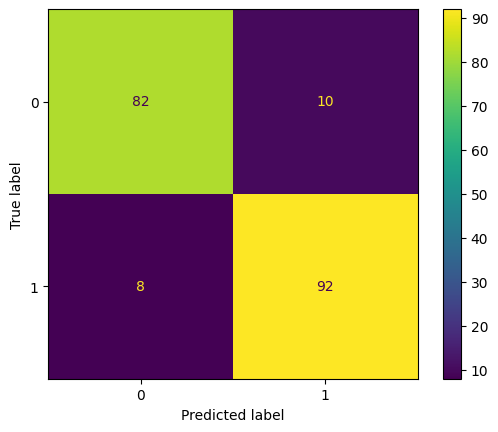

In [72]:
model = TorchModel(best_model)
y_train_pred_bin = model.predict(train_dataloader)
y_valid_pred_bin = model.predict(valid_dataloader)
y_test_pred_bin = model.predict(test_dataloader)

# df = def_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
#                                                # ! proposed bin not price

# start_capital = 100000
# tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
# bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
# traded_capital = tt.trade()
# maximal_caital = bt.trade()
# print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {model.score(train_dataloader, y_train):.2f}")
print(f"Valid accuracy {model.score(valid_dataloader, y_valid):.2f}")
print(f"Test accuracy  {model.score(test_dataloader, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_bin)

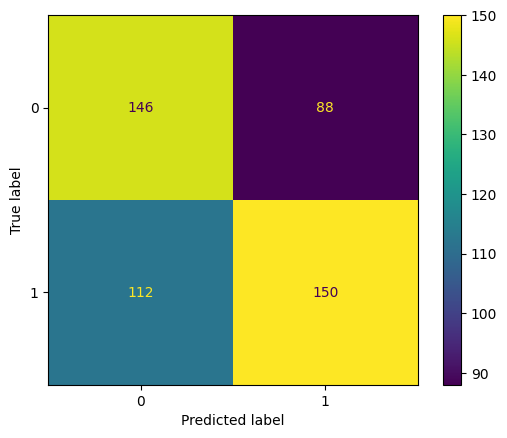

In [52]:
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)

In [371]:
model.predict(X_test)

,0
0,0
1,0
2,0
3,0
4,0
...,...
393,1
394,1
395,1
396,0


In [156]:
y_test

pandas.core.frame.DataFrame

In [380]:
byt = market.BinYearTest(tickers, HistBinPipeline, end_date=None, window_size=15)

In [381]:
year_test_df = byt.trade(model)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


In [382]:
year_test_df

,Month,TrainAcc,TestAcc,Income,Potential
0,May_2022,0.516807,0.533333,0.978148,-0.074632
1,Jun_2022,0.472574,0.562500,0.977978,-0.215529
2,Jul_2022,0.476793,0.875000,1.289307,1.000000
3,Aug_2022,0.474576,0.647059,0.921597,-0.699981
4,Sep_2022,0.443038,0.611111,1.034370,0.225082
5,Oct_2022,0.489451,0.529412,1.011978,0.065914
6,Nov_2022,0.461864,0.500000,0.999834,-0.001554
7,Dec_2022,0.451477,0.411765,0.744636,-3.025827
8,Jan_2023,0.451477,0.714286,1.134413,0.451173
9,Feb_2023,0.453390,0.400000,0.917766,-0.345302


In [383]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)

Year capital multiplier 0.8808527581885512


## Regression data

In [86]:
from process import *

class HistPipeline(DefaultPipeline):        
    def _stages(self):
        stages=[
            # Open processing
            DivStage("Open", "Close", "Open_Rel"),
            DropStage(["Open"]),
            # High processing
            DivStage("High", "Close", "High_Rel"),
            DropStage(["High"]),
            # Low processing
            DivStage("Low", "Close", "Low_Rel"),
            DropStage(["Low"]),
            # AdjClose processing
            DropStage(["Adj Close"]),
            # Volume processing
            DropStage(["Volume"]),
            
            # RSI
            RSIColStage("Close"),
            
            LnProfStage("Close"),
            WindowStage(self.window_size),
            TargetStage(f"Close_LnProf_{self.window_size-1}"),

#             BinarizeStage(0., "Target"),
#             DropStage(["Target"]),
#             TargetStage("Target_Bin"),
            
            DropStage([f"Open_Rel_{self.window_size-1}"]),
            DropStage([f"High_Rel_{self.window_size-1}"]),
            DropStage([f"Low_Rel_{self.window_size-1}"]),

            DropStage([f"Close_{i}" for i in range(self.window_size-2)]),
            DropStage([f"RSI_{self.window_size-1}"]),
            TrainTestStage(test=self.test_coef),
            PopStage([f"Close_{self.window_size-2}"], self.prev_price_keeper),
            PopStage([f"Close_{self.window_size-1}"], self.true_price_keeper),
            TargetsSeparateStage(),
        ]
        return stages


In [99]:
tickers = ["TSLA"]# "AAPL", "MSFT", "AMZN", "GOOGL"]
# CNN model won't be re-learned foreach case separately, so,
# it should know the year test data
# For "5y" test_coef is 0.22
window_size = 15

def_pipe = HistPipeline(tickers, period="10y", test_coef=0.22/2, window_size=window_size)
X_train, y_train, X_test, y_test = def_pipe.get_data()

X_train[[f"RSI_{i}" for i in range(14)]] /= 100
X_test[[f"RSI_{i}" for i in range(14)]] /= 100
X_train[[f"RSI_{i}" for i in range(14)]]

[*********************100%***********************]  1 of 1 completed


,RSI_0,RSI_1,RSI_2,RSI_3,RSI_4,RSI_5,RSI_6,RSI_7,RSI_8,RSI_9,RSI_10,RSI_11,RSI_12,RSI_13
0,1.000000,0.692130,0.724213,0.818532,0.789115,0.730323,0.651570,0.640492,0.720705,0.765374,0.846111,0.729772,0.732000,0.610258
1,0.692130,0.724213,0.818532,0.789115,0.730323,0.651570,0.640492,0.720705,0.765374,0.846111,0.729772,0.732000,0.610258,0.540632
2,0.724213,0.818532,0.789115,0.730323,0.651570,0.640492,0.720705,0.765374,0.846111,0.729772,0.732000,0.610258,0.540632,0.563949
3,0.818532,0.789115,0.730323,0.651570,0.640492,0.720705,0.765374,0.846111,0.729772,0.732000,0.610258,0.540632,0.563949,0.569492
4,0.789115,0.730323,0.651570,0.640492,0.720705,0.765374,0.846111,0.729772,0.732000,0.610258,0.540632,0.563949,0.569492,0.590440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,0.454801,0.406752,0.377752,0.431273,0.482967,0.521306,0.559221,0.576096,0.643892,0.648161,0.660803,0.655188,0.718875,0.724099
2224,0.406752,0.377752,0.431273,0.482967,0.521306,0.559221,0.576096,0.643892,0.648161,0.660803,0.655188,0.718875,0.724099,0.713787
2225,0.377752,0.431273,0.482967,0.521306,0.559221,0.576096,0.643892,0.648161,0.660803,0.655188,0.718875,0.724099,0.713787,0.683019
2226,0.431273,0.482967,0.521306,0.559221,0.576096,0.643892,0.648161,0.660803,0.655188,0.718875,0.724099,0.713787,0.683019,0.689173


In [100]:
y_train

,Target
0,-0.054334
1,0.024010
2,0.005573
3,0.020549
4,0.047052
...,...
2223,-0.005088
2224,-0.015095
2225,0.006466
2226,0.054596


In [101]:
CHANNELS = 5

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32).flatten()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training_data = CustomStockDataset(X_train, y_train)
test_data = CustomStockDataset(X_test[:31], y_test[:31])

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True, drop_last=True)

In [102]:
X_train.shape, X_test.shape

((2228, 70), (275, 70))

In [103]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class forecasting_model(nn.Module):
    
    def __init__(self, input_features, output_features, print_shapes = False):
        super().__init__()
        self.conv    = nn.Conv1d(in_channels = input_features, out_channels = 128, kernel_size = 3, padding = 1)
        self.pool1   = nn.AdaptiveAvgPool1d(1)
        self.pool2   = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.bn      = nn.BatchNorm1d(num_features = 2 * 128)
        self.relu    = nn.ReLU()
        self.fc      = nn.Linear(in_features = 2 * 128, out_features = output_features)
        self.print_shapes = print_shapes
        
    def forward(self, x):
        
        if self.print_shapes: print(f"{'Input Batch Shape':<25} {x.shape}")
        
        conv_op = self.conv(x)
        if self.print_shapes: print(f"{'Conv Output Shape':<25} {conv_op.shape}")
        
        avg_pool = self.pool1(conv_op)
        max_pool = self.pool2(conv_op)
        final_pool = torch.cat([avg_pool, max_pool], dim = -1)
        flattened_op = self.flatten(final_pool)
        if self.print_shapes: print(f"{'Pooled Output Shape':<25} {flattened_op.shape}")
        
        final_op = self.fc(self.bn(self.relu(flattened_op)))
        if self.print_shapes: print(f"{'Output Shape':<25} {final_op.shape}")
            
        return final_op
    
torch_model = forecasting_model(CHANNELS, 1, False)
summary(torch_model, (CHANNELS, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 14]           2,048
 AdaptiveAvgPool1d-2               [-1, 128, 1]               0
 AdaptiveMaxPool1d-3               [-1, 128, 1]               0
           Flatten-4                  [-1, 256]               0
              ReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                    [-1, 1]             257
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [85]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
torch_model = LSTM(70)
summary(torch_model, (CHANNELS, 14))

AttributeError: 'tuple' object has no attribute 'size'

In [104]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(torch_model.parameters(), lr = 3e-3, momentum=0.9)

# for regression
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)

train_loss = []
test_acc = []
best_model = None
best_acc = 0

In [105]:
import copy

C:\Users\valer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[21,     3] loss: 0.001 | test acc: 0.387

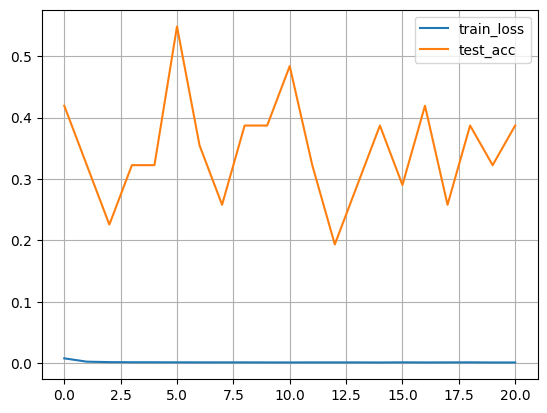

Finished Training


In [106]:
for epoch in range(20+1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = model(inputs.reshape([inputs.shape[0], 2, 14]))
        outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
#         print(outputs, labels)
        loss = criterion(outputs, labels)
#         print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = len(train_dataloader)
        if i % step == step - 1: 
            train_loss.append(running_loss / step)

            with torch.no_grad():
                predicred_true = 0
                for i, data in enumerate(test_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, 14]))
                    labels[labels>=0] = 1
                    labels[labels<0] = 0
                    labels = labels.long().flatten()
                    outputs[outputs>=0] = 1
                    outputs[outputs<0] = 0
                    outputs = outputs.long().flatten()
#                     print(outputs, labels)
                    predicred_true += int(sum(outputs == labels))
#                     print(predicred_true)

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                test_acc.append(predicred_true/ len(test_dataloader.dataset))
            print(f'\r[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} | test acc: {predicred_true/ len(test_dataloader.dataset):.3f}', end='', flush=True)
            running_loss = 0.0
            
            if predicred_true/ len(test_dataloader.dataset) > best_acc:
                best_model = copy.deepcopy(torch_model)
                best_acc = predicred_true/ len(test_dataloader.dataset)
                
plt.plot(train_loss, label="train_loss")
plt.plot(test_acc, label="test_acc")
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')

In [107]:
class TorchModel:
    def __init__(self, model):
        self.model = model

    def fit(self, x_data, y_data):
        return self

    def predict(self, data):
        y_preds = None
        with torch.inference_mode(): 
            y_preds = self.model(torch.tensor(np.array(data).astype(np.float32).reshape([data.shape[0], CHANNELS, 14]), dtype=torch.float))
            y_preds = np.argmax(np.array(y_preds), axis=1)
        return pd.DataFrame(y_preds)
    
    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)

C:\Users\valer\Desktop\SPP\SPP\model\../spp\process.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


Model earned 100000.00$ out of 29596.77$ starting from 100000$ 
Train accuracy 0.48 
Test accuracy  0.00


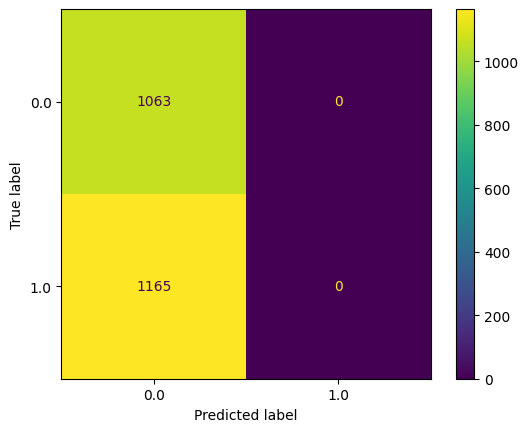

In [111]:
model = TorchModel(best_model)
y_train_pred_bin = model.predict(X_train)
y_test_pred_bin = model.predict(X_test)

df = def_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
                                               # ! proposed bin not price

start_capital = 100000
tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
traded_capital = tt.trade()
maximal_caital = bt.trade()
print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {model.score(X_train, y_train):.2f} \nTest accuracy  {model.score(X_test, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_bin)

In [108]:
y_train[y_train >= 0] = 1
y_train[y_train <0 ] = 0
y_train.sum() / len(y_train)

Target    0.52289
dtype: float64